In [361]:
import statistics
import math
import random
import sys
import copy
import matplotlib.pyplot as plt

limit = 100000000

bw, n, m, deadline, e = 0, 0, 0, 0, 0
edges = []
size = []
energy_model = []
cc = []

with open("50.txt", "r") as file:
    data = file.readlines()
    word = data[0]
    a_list = word.split()
    map_object = map(int, a_list)
    temp = list(map_object)
    
    bw = temp[0]
    n = temp[1]
    m = temp[2]
    deadline = temp[3]
    e = temp[4]
    
    for i in range(1,1+e):
        word = data[i]
        a_list = word.split()
        map_object = map(int, a_list)
        temp = tuple(map_object)
        edges.append(temp)
        
    ptr = 1+e
    
    word = data[ptr]
    a_list = word.split()
    map_object = map(int, a_list)
    size = list(map_object)
    
    ptr += 1
    
    word = data[ptr]
    a_list = word.split()
    map_object = map(int, a_list)
    cc = list(map_object)
    
    ptr += 1
    
    for i in range(ptr,ptr+n):
        word = data[i]
        a_list = word.split()
        map_object = map(int, a_list)
        temp = list(map_object)
        energy_model.append(temp)
    
number_of_iterations = 500
N = 40 # population size


In [362]:
# Class defining virtual machine type
class VirtualMachine:
    
    # Constructor for initialising the virtual machine
    def __init__(self,cc):
        # cc is CPU capacity
        self.cc = cc


In [363]:
# Class defining virtual machine instance
class MachineInstance:

    # Constructor for initialising virtual machine instance
    def __init__(self,id,type):
        # ID of Machine instance (assigned serially)
        self.id = id
        # Virtual Machine Type of this instance
        self.type = type
        # Tasks mapped to this instance in the form of tuples (Task ID, Start Time, Finish Time)
        self.tasks_mapped = []

    # Method to print VM instance details
    def printInstance(self):
        print("ID: ",self.id)
        print("VM Type: ",self.type)
        print(self.tasks_mapped)
        

In [364]:
# Class defininf particles in PSO
class Particle:
    
    # Contructor for initialising particle
    def __init__(self,data,n):
        # Number of tasks, dimension of particles is 2n
        self.n = n
        # List representing the position vector
        self.data = []
        # List representing the velocity vector
        self.velocity = []
        
        for i in range(2*n):
            self.data.append(data[i])
            self.velocity.append(random.random())
            
    # Method to print particle encoding
    def ShowParticle(self):
        for i in range(2*self.n):
            print(self.data[i],end=' ')


In [365]:
# Class defining workflow in the form of DAG (Directed Acyclic Graph)
class Workflow:

    # Constructor to initialise a workflow
    def __init__(self, size, edges, deadline, n):
 
        # A list of lists to represent an adjacency list
        self.adjList = [None] * n
        # A list of lists to represent inverse adjacency list
        self.adjList2 = [None] * n
        # A list representing number of instructions in each task
        self.size = []
        # Initialising deadline
        self.deadline = deadline
        # Latest finish time of each task 
        self.lft = [None] * n
        # CC of fastest VM Type
        self.temp = 0
 
        # Allocate memory for the adjacency lists
        for i in range(n):
            self.adjList[i] = []
            self.adjList2[i] = []
 
        # Add edges to the directed graph
        for (src, dst, weight) in edges:
            # Allocate node in adjacency list from src to dst
            self.adjList[src].append((dst, weight))
            # Allocate node in adjacency list from dst to src
            self.adjList2[dst].append((src, weight))
            
        # Assign number of instructions to each task
        for num in size:
            self.size.append(num)

        # Finding the fastest VM type
        self.temp = 0.0
        for i in vm:
            self.temp = max(self.temp,i.cc)

        # Calculating LFT
        self.FindLFT(0)
            
    # Function to print workflow
    def ShowGraph(self):
        for src in range(len(self.adjList)):
            for (dst,weight) in self.adjList[src]:
                print(f'({src} —> {dst}, {weight}) ', end='')
            
        print()
        
        for dst in range(len(self.adjList2)):
            for (src, weight) in self.adjList2[dst]:
                print(f'({dst} —> {src}, {weight}) ', end='')
        
        print()

    def FindLFT(self,src):
        if(self.lft[src]==None):
            if(self.adjList[src]==[]):
                self.lft[src] = self.deadline
            else:
                self.lft[src] = sys.float_info.max
                for x in self.adjList[src]:
                    self.lft[src] = min(self.lft[src],self.FindLFT(x[0]) - self.size[x[0]]/self.temp - x[1]/bw)
        return self.lft[src]
        
  

In [366]:
class Solution:

    # Constructor to initialise solution
    def __init__(self):
        self.schedule = []
        self.makespan = 0
        self.energy = 0
        self.loadBalance = 0
        fitnessFunc = 0
        
    # Method to evaluate objective function
    def findFittness(self):
        fitnessFunc = 0
        if(self.makespan > w1.deadline):
            fitnessFunc = limit
        else:
            fitnessFunc = 0.5 * self.makespan + 0.25 * self.energy + 0.25 * self.loadBalance
        return fitnessFunc # added
        
    # Method to print the solution
    def printSchedule(self):
        for i in range(n):
            print(self.schedule[i])
            print()
            
        print("Makespan % s" %(self.makespan))
        print("Energy % s" %(self.energy))
        print("Standard Deviation % s" %(math.sqrt((self.loadBalance))))
        print("Fittness % s" %(self.findFittness()))

In [367]:

def Decode(p1):
    sol1 = Solution()

    id = 0
    
    # Contains the tasks sorted according to the priority order present in the particle
    order = []
    
    for i in range(n):
        order.append((i,p1.data[n+i]))
        
    order.sort(key = lambda a : a[1])
    R = []

    for i in range(n):
        sol1.schedule.append({"VM Type": round(p1.data[i]), "VM Instance": -1, "ST": 0, "FT": 0})

    for i in range(n):
        H = []
        task_id = order[i][0]
        vm_type = round(p1.data[task_id])

        #print("Iteration ", task_id)

        #Selecting serial and parallel instances for Ti
        X = []
        Y = []

        for vmi in R:
            if(vmi.type == vm_type):
                flag = 0
                for (parent,weight) in w1.adjList2[task_id]:
                    for (task_id1,st,ft) in vmi.tasks_mapped:
                        if(parent==task_id1):
                            flag = 1
                            break
                    if(flag==1):
                        break
                if(flag==1):
                    X.append(vmi)
                else:
                    Y.append(vmi)
        
        for vmi in X:
            # Calculation of EST
            est = 0
            for (parent,weight) in w1.adjList2[task_id]:
                if(sol1.schedule[parent]["VM Instance"]==vmi):
                    est = max(est, sol1.schedule[parent]["FT"])
                else:
                    est = max(est, sol1.schedule[parent]["FT"] + weight/bw)
            #print(task_id, est)

            st = est
            ft = st + size[task_id] / vm[vm_type].cc
            if(ft <= vmi.tasks_mapped[0][1] and ft <= w1.lft[task_id]):
                H.append((vmi,st,ft))
            else:
                for j in range(len(vmi.tasks_mapped)):
                    if(j<len(vmi.tasks_mapped)-1):
                        st = max(est,vmi.tasks_mapped[j][2])
                        ft = st + size[task_id] / vm[vm_type].cc
                        if(ft <= w1.lft[task_id] and ft<=vmi.tasks_mapped[j+1][1]):
                            H.append((vmi,st,ft))
                            break
                    else:
                        st = max(est,vmi.tasks_mapped[j][2])
                        ft = st + size[task_id] / vm[vm_type].cc
                        if(ft <= w1.lft[task_id]):
                            H.append((vmi,st,ft))
                            break

        if(H==[]):
            for vmi in Y:
                # Calculation of EST
                est = 0
                for (parent,weight) in w1.adjList2[task_id]:
                    if(sol1.schedule[parent]["VM Instance"]==vmi):
                        est = max(est, sol1.schedule[parent]["FT"])
                    else:
                        est = max(est, sol1.schedule[parent]["FT"] + weight/bw)
                #print(task_id, est)

                st = est
                ft = st + size[task_id] / vm[vm_type].cc
                if(ft <= vmi.tasks_mapped[0][1] and ft <= w1.lft[task_id]):
                    H.append((vmi,st,ft))
                else:
                    for j in range(len(vmi.tasks_mapped)):
                        if(j<len(vmi.tasks_mapped)-1):
                            st = max(est,vmi.tasks_mapped[j][2])
                            ft = st + size[task_id] / vm[vm_type].cc
                            if(ft <= w1.lft[task_id] and ft<=vmi.tasks_mapped[j+1][1]):
                                H.append((vmi,st,ft))
                                break
                        else:
                            st = max(est,vmi.tasks_mapped[j][2])
                            ft = st + size[task_id] / vm[vm_type].cc
                            if(ft <= w1.lft[task_id]):
                                H.append((vmi,st,ft))
                                break

        if(H==[]):
            vm_instance = MachineInstance(id,vm_type)
            id += 1
            est = 0
            
            for (parent, weight) in w1.adjList2[task_id]:
                est = max(est, sol1.schedule[parent]["FT"] + weight/bw)
            
            ft = est + size[task_id] / vm[vm_type].cc
            vm_instance.tasks_mapped.append((task_id,est,ft))
            sol1.schedule[task_id]["VM Instance"] = vm_instance.id
            sol1.schedule[task_id]["ST"] = est
            sol1.schedule[task_id]["FT"] = ft
            R.append(vm_instance)
        else:
            req_ins = None
            min_tasks = 1000000000
            for x in H:
                if(len(x[0].tasks_mapped)<min_tasks):
                    min_tasks = len(x[0].tasks_mapped)
                    req_ins = x
            req_ins[0].tasks_mapped.append((task_id,req_ins[1],req_ins[2]))
            sol1.schedule[task_id]["VM Instance"] = req_ins[0].id
            sol1.schedule[task_id]["ST"] = req_ins[1]
            sol1.schedule[task_id]["FT"] = req_ins[2]
        
    for i in range(n):
        sol1.makespan = max(sol1.makespan,sol1.schedule[i]["FT"])
        sol1.energy += ((sol1.schedule[i]['FT'] - sol1.schedule[i]['ST']) * energy_model[i][sol1.schedule[i]['VM Type']])

    time_engaged = []
    for i in R:
        sum = 0
        for j in i.tasks_mapped:
            sum += (j[2] - j[1])
        time_engaged.append(sum)

    if(len(time_engaged)<2):
        sol1.loadBalance = limit
    else:
        sol1.loadBalance = statistics.variance(time_engaged)
    return sol1

In [368]:
def GetParents(task_id):
    return [x[0] for x in w1.adjList2[task_id]]

In [369]:
def RepairTasks(p, n):
    '''
    p: particle to be repaired
    n: number of tasks (task set: {0, 1, 2, ... n-1})
    
    '''
    # round the task priorities (η -> rounded priorities)
    η = [None] * n
    for i in range(n):
        η[i] = round(p.data[i+n])
    
    # V -> set of tasks with valid priorities
    V = set()
    # Task set
    T = {i for i in range(n)}
    
    # Entery task always has valid priority
    V.add(0)
    T.remove(0)
    
    while len(T) != 0:
        # Q -> set of tasks whose all parents are in V
        Q = set()
        
        for t in T:
            parents = GetParents(t)
            all_in_V = True
            for parent in parents:
                if parent not in V:
                    all_in_V = False
                    break
            if all_in_V:
                Q.add(t)
                
        # V_max = max priority in set V
        V_max = max([η[task_id] for task_id in V])
        
        for t in Q:
            parents = GetParents(t)
            P_max = max([η[task_id] for task_id in parents])
            
            if η[t] <= P_max:
                η[t] = P_max + 1
            
            if η[t] in [η[task_id] for task_id in V]:
                η[t] = V_max + 1
            
            V.add(t)
            T.remove(t)
            
    for i in range(n):
        p.data[i+n] = η[i]
    
    return p
        

In [370]:
def AverageExecutionCost():
    average_cost = [0] * n
    
    for i in range(m):
        cc = vm[i].cc
        for j in range(n):
            average_cost[j] += w1.size[j]/cc
    
    for i in range(n):
        average_cost[i] = average_cost[i]/m
    
    return average_cost

In [371]:
def GetDownwardRanks():
    ranks = [-1] * n    
    average_cost = AverageExecutionCost()
    
    bfs_queue = []
    
    bfs_queue.append(0)
    ranks[0] = average_cost[0]
    
    while len(bfs_queue) > 0:
        top = bfs_queue.pop(0)
        
        for succ in w1.adjList[top]:
            ranks[succ[0]] = max(ranks[succ[0]], average_cost[succ[0]] + succ[1]/bw + ranks[top])
            if ranks[succ[0]] == -1:
                bfs_queue.append(succ)
    
    return ranks

In [372]:
def GetUpwardRanks(ranks = [-1] * n, src = 0):
    if src == n-1:
        ranks[src] = 0
        return ranks
    
    for succ in w1.adjList[src]:
        ranks = GetUpwardRanks(ranks, succ[0])
        ranks[src] = max(ranks[src], succ[1]/bw + AverageExecutionCost()[succ[0]] + ranks[succ[0]])
    
    return ranks
    

In [373]:
def GetPopulation(N):
    upward_ranks = GetUpwardRanks()
    downward_ranks = GetDownwardRanks()
    
    σ = max(upward_ranks)
    
    O1 = []
    for i in range(N):
        data = [random.randint(0, m-1) for i in range(2*n)]
        for j in range(n):
            data[j+n] = downward_ranks[j]
            
        p = Particle(data, n)
        O1.append(p)
    
    O2 = []
    for i in range(N):
        data = [random.randint(0, m-1) for i in range(2*n)]
        for j in range(n):
            data[j+n] = σ - upward_ranks[j]
            
        p = Particle(data, n)
        O2.append(p)
    
    fitness_values = []
    
    # If only makespan is to be minimised
    temp = sys.float_info.min
    id = -1
    for i in range(len(vm)):
        if(vm[i].cc>temp):
            id = i
            temp = vm[i].cc

    data = []
    for i in range(2*n):
        data.append(id)

    for i in range(n):
        data[i+n] = downward_ranks[i]
    p = Particle(data, n)
    O1.append(p)
    for i in range(n):
        data[i+n] = σ - upward_ranks[i]
    O2.append(p)

    # If only energy is to be minimised
    for i in range(n):
        temp = sys.float_info.max
        id = -1
        for j in range(len(vm)):
            if(energy_model[i][j]<temp):
                temp = energy_model[i][j]
                id = j
        data[i] = id

    for i in range(n):
        data[i+n] = downward_ranks[i]
    p = Particle(data, n)
    O1.append(p)
    for i in range(n):
        data[i+n] = σ - upward_ranks[i]
    O2.append(p)
    
    for p in O1:
        p = RepairTasks(p,n)
        fitness_values.append((Decode(p).findFittness(), p))
    
    for p in O2:
        p = RepairTasks(p,n)
        fitness_values.append((Decode(p).findFittness(), p))
    
    fitness_values.sort(key = lambda x: x[0])
    
    return ([val[0] for val in fitness_values[0:N]], [val[1] for val in fitness_values[0:N]])


In [374]:
x_axis = []
y_axis = []
x_global = []
y_global = []
def PSO_Solver():
    inertia_weight = random.uniform(0,0.35)
    c1 = 2
    c2 = 2
    r1 = random.random()
    r2 = random.random()

    fitness, population = GetPopulation(N)

    for i in range(N):
        x_axis.append(0)
        y_axis.append(fitness[i])
    
    particle_best_position = copy.deepcopy(population)
    global_best_position = copy.deepcopy(particle_best_position[0])
    best_fitness = fitness[0]
    best_particle = 0
    
    for t in range(number_of_iterations):
        for p_id in range(len(population)):
            for i in range(2*n):
                if(fitness[p_id]==limit):
                    population[p_id].velocity[i] = inertia_weight * population[p_id].velocity[i] + c2 * r2 * (global_best_position.data[i] - population[p_id].data[i])
                else:
                    population[p_id].velocity[i] = inertia_weight * population[p_id].velocity[i] + c1 * r1 * (particle_best_position[p_id].data[i] - population[p_id].data[i]) + c2 * r2 * (global_best_position.data[i] - population[p_id].data[i])
            for i in range(2*n):
                population[p_id].data[i] = population[p_id].data[i] + population[p_id].velocity[i]
            
            for i in range(n):
                population[p_id].data[i] = round(population[p_id].data[i])
                population[p_id].data[i] = min(population[p_id].data[i], m-1)
                population[p_id].data[i] = max(population[p_id].data[i], 0)
                    
            population[p_id] = RepairTasks(population[p_id],n)
            sol = Decode(population[p_id])
            score = sol.findFittness()
            x_axis.append(t)
            y_axis.append(score)

            if(score < fitness[p_id]):
                #print("Value Changed")
                fitness[p_id] = score
                particle_best_position[p_id] = copy.deepcopy(population[p_id])
        
            if(score < best_fitness):
                best_fitness = score
                best_particle = p_id

            x_global.append(t)
            y_global.append(best_fitness)
        c1 = c1 * 0.99
        #c2 = c2 * 1.003
        inertia_weight = inertia_weight * 0.8
    
    #print(best_particle)
    global_best_position = particle_best_position[best_particle]

    plt.plot(x_axis, y_axis, color='red', linestyle='none', linewidth = 0,
         marker='o', markerfacecolor='blue', markersize=3)
 
    # setting x and y axis range
    plt.ylim(7000,10000)
    plt.xlim(0,500)
    
    # naming the x axis
    plt.xlabel('number of iterations')
    # naming the y axis
    plt.ylabel('fitness value')
    
    # giving a title to my graph
    plt.title('Converging')
    
    # function to show the plot
    plt.plot(x_axis, [best_fitness] * len(x_axis), color='blue',linewidth = 1)
    plt.plot(x_global, y_global, color='green',linewidth=1)
    plt.show()

    return Decode(global_best_position)

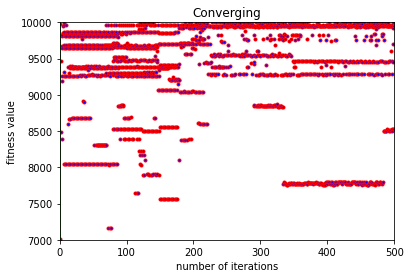

{'VM Type': 1, 'VM Instance': 0, 'ST': 0, 'FT': 0.0}

{'VM Type': 0, 'VM Instance': 1, 'ST': 0, 'FT': 11.296296296296296}

{'VM Type': 1, 'VM Instance': 0, 'ST': 161.95679012345678, 'FT': 169.20679012345678}

{'VM Type': 0, 'VM Instance': 1, 'ST': 107.09876543209877, 'FT': 113.74074074074075}

{'VM Type': 0, 'VM Instance': 2, 'ST': 177.78086419753086, 'FT': 187.44753086419752}

{'VM Type': 0, 'VM Instance': 1, 'ST': 143.53086419753086, 'FT': 155.45679012345678}

{'VM Type': 0, 'VM Instance': 2, 'ST': 155.95679012345678, 'FT': 167.09259259259258}

{'VM Type': 0, 'VM Instance': 1, 'ST': 11.296296296296296, 'FT': 22.24691358024691}

{'VM Type': 0, 'VM Instance': 1, 'ST': 22.24691358024691, 'FT': 32.79012345679012}

{'VM Type': 0, 'VM Instance': 2, 'ST': 78.7716049382716, 'FT': 88.52469135802468}

{'VM Type': 0, 'VM Instance': 1, 'ST': 113.74074074074075, 'FT': 125.54320987654322}

{'VM Type': 0, 'VM Instance': 2, 'ST': 241.5185185185185, 'FT': 247.85185185185185}

{'VM Type': 0, 'VM Insta

In [375]:
vm = []
# Initialising CPU capacity of each VM type
for i in cc:
    vm.append(VirtualMachine(i))
w1 = Workflow(size,  edges, deadline , n)
PSO_Solver().printSchedule()